In [1]:
import numpy as np
import h5py
from scipy.io import loadmat
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings

In [2]:
# Sets data location
experiment = 'E338'
runname = '12691'

In [3]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

In [4]:
# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

# Sets the calibration value for SYAG in eV/m
SYAG_cal = 64.4e9


### Load dataset

In [5]:
# Loads dataset
dataloc = './' + experiment + '/' + experiment + '_' + runname + '/' + experiment + '_'  +runname + '.mat'
mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
data_struct = mat['data_struct']

In [6]:
# Extracts number of steps
stepsAll = data_struct.params.stepsAll
if stepsAll is None or len(np.atleast_1d(stepsAll)) == 0:
    stepsAll = 1

# calculate xt calibration factor
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

### Grab XTCAV images on DTOTR2

In [7]:
DTOTR2data = None

for a in range(len(stepsAll)):
    raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    DTOTR2datalocation = './E338/' + match.group(0)

    with h5py.File(DTOTR2datalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    # Transpose to shape: (H, W, N)
    data_transposed = np.transpose(data_raw, (2, 1, 0))

    if DTOTR2data is None:
        DTOTR2data = data_transposed
    else:
        DTOTR2data = np.concatenate((DTOTR2data, data_transposed), axis=2)

In [8]:
# Keeps only the data with a common index
DTOTR2commonind = data_struct.images.DTOTR2.common_index -1 
DTOTR2data = DTOTR2data[:, :, DTOTR2commonind]

nshots = DTOTR2data.shape[2]


### Rotate the DTOTR2 images so they look like they do on profmon GUIs

In [9]:
xtcavImages = DTOTR2data - data_struct.backgrounds.DTOTR2[:,:,np.newaxis].astype(np.float64)

### Get the XTCAV phase on each shot (important if toggler is on)

In [10]:
def matstruct_to_dict(obj):
    """
    Recursively convert MATLAB structs (loaded via scipy.io.loadmat) to Python dictionaries.
    """
    if isinstance(obj, scipy.io.matlab.mio5_params.mat_struct):
        result = {}
        for fieldname in obj._fieldnames:
            result[fieldname] = matstruct_to_dict(getattr(obj, fieldname))
        return result
    elif isinstance(obj, np.ndarray):
        if obj.dtype == 'object':
            return [matstruct_to_dict(o) for o in obj]
        else:
            return obj
    else:
        return obj

In [11]:
def extractDAQBSAScalars(data_struct):
    data_struct = matstruct_to_dict(data_struct)
    dataScalars = data_struct['scalars']
    idx = dataScalars['common_index'].astype(int).flatten()

    fNames = list(dataScalars.keys())
    isBSA = [name for name in fNames if name.startswith('BSA_List_')]

    bsaScalarData = []
    bsaVarPVs = []

    for bsaName in isBSA:
        bsaList = dataScalars[bsaName]
        varNames = list(bsaList.keys())
        bsaListData = []

        for varName in varNames:
            varData = np.array(bsaList[varName]).squeeze()
            if varData.size == 0:
                continue
            varData = varData[idx]  # apply common index
            varData = np.nan_to_num(varData)  # replace NaN with 0
            bsaListData.append(varData)

        # Add to output arrays
        bsaVarPVs.extend([vn for vn in varNames if bsaList[vn].size != 0])
        if bsaListData:
            bsaScalarData.extend(bsaListData)

    bsaScalarData = np.array(bsaScalarData)
    return bsaScalarData, bsaVarPVs


In [12]:
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct)

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_76497/2963694151.py:5: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(obj, scipy.io.matlab.mio5_params.mat_struct):


In [13]:
ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = bsaScalarData[ampl_idx, :]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = bsaScalarData[phase_idx, :]

In [14]:
xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

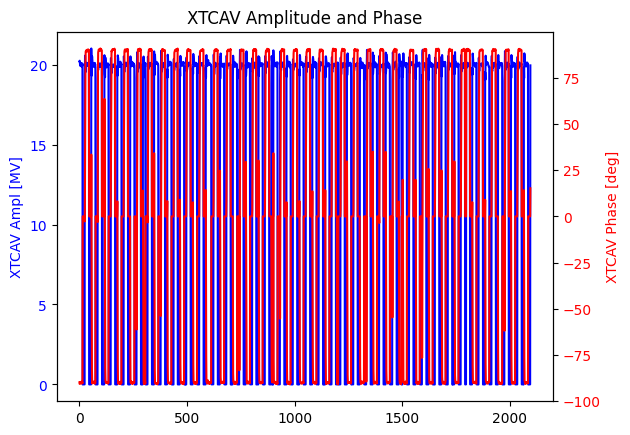

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(xtcavAmpl, label='Amplitude', color='b')
ax1.set_ylabel('XTCAV Ampl [MV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(xtcavPhase, label='Phase', color='r')
ax2.set_ylabel('XTCAV Phase [deg]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('XTCAV Amplitude and Phase')
plt.show()

### Plot sample images of the beam with tcav at +90 deg, 0 and -90 deg

In [16]:

def cropProfmonImg(img, xrange, yrange, plot_flag=False):
    """
    Crop a 2D image around the peak of horizontal and vertical projections,
    returning a region of shape (2*yrange, 2*xrange), with padding if needed.

    Args:
        img (2D np.ndarray): Input image.
        xrange (int): Half-width in x-direction.
        yrange (int): Half-height in y-direction.
        plot_flag (bool): If True, show plots.

    Returns:
        cropped_img (2D np.ndarray): Cropped image (always 2*yrange by 2*xrange).
        error_flag (int): 0 if successful, 1 if fallback used.
    """
    img = img.astype(float)
    img_h, img_w = img.shape

    # Use max projections to find "COM"
    x_com = int(np.argmax(np.sum(img, axis=0)))
    y_com = int(np.argmax(np.sum(img, axis=1)))

    # Desired window size
    x_start = x_com - xrange
    x_end   = x_com + xrange
    y_start = y_com - yrange
    y_end   = y_com + yrange

    # Compute required padding if indices go out of bounds
    pad_left   = max(0, -x_start)
    pad_right  = max(0, x_end - img_w)
    pad_top    = max(0, -y_start)
    pad_bottom = max(0, y_end - img_h)

    # Pad image as needed
    if any([pad_left, pad_right, pad_top, pad_bottom]):
        img = np.pad(img, 
                     ((pad_top, pad_bottom), (pad_left, pad_right)), 
                     mode='constant', constant_values=0)
        error_flag = 1  # Fallback was needed
    else:
        error_flag = 0

    # Recalculate indices after padding
    x_start += pad_left
    x_end   += pad_left
    y_start += pad_top
    y_end   += pad_top

    # Crop
    cropped_img = img[y_start:y_end, x_start:x_end]

    # Sanity check
    if cropped_img.shape != (2*yrange, 2*xrange):
        warnings.warn(f"Cropped image shape mismatch: got {cropped_img.shape}")
        error_flag = 1

    if plot_flag:
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))
        axs[0].imshow(img, cmap='viridis', aspect='auto')
        axs[0].set_title("Original / Padded Image")
        axs[1].imshow(cropped_img, cmap='viridis', aspect='auto')
        axs[1].set_title("Cropped Image")
        plt.tight_layout()
        plt.show()

    return cropped_img, error_flag


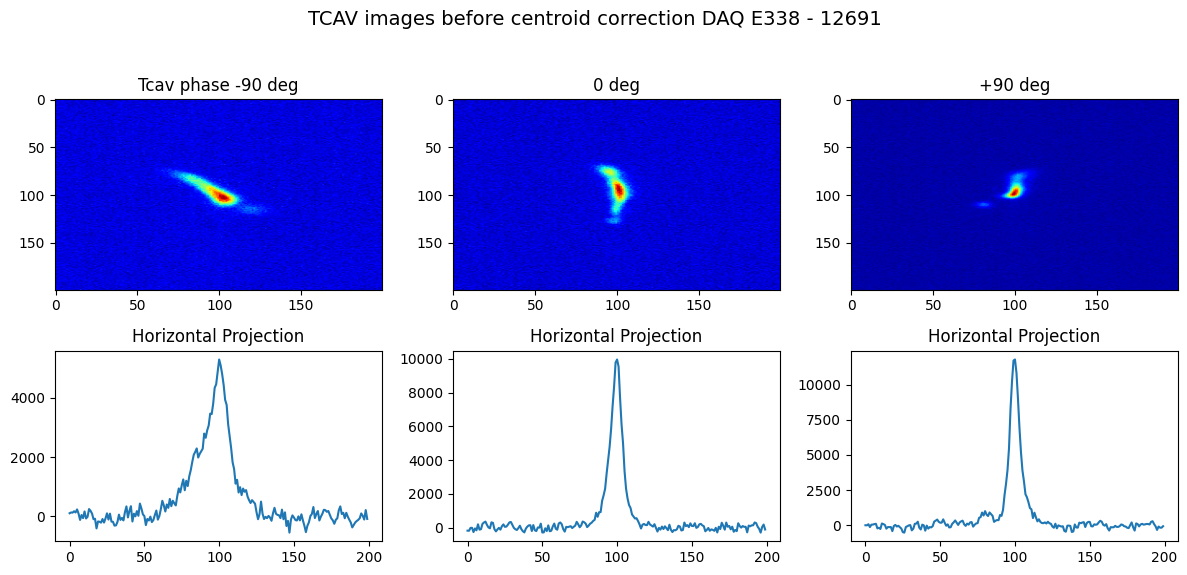

In [17]:
# Find the first shot where tcav is at -90, 0 and +90 deg
near_minus_90_idx = np.where((xtcavPhase >= -90.55) & (xtcavPhase <= -89.55))[0][0]
near_plus_90_idx = np.where((xtcavPhase >= 89.55) & (xtcavPhase <= 90.55))[0][0]
zero_idx = np.where(xtcavPhase == 0)[0][1]

sample_image_indices = [near_minus_90_idx, zero_idx, near_plus_90_idx]
plot_titles = ['Tcav phase -90 deg', '0 deg', '+90 deg']


# Define the x and yrange for cropping the image; Need to automate this
# figure;imagesc(sampleImage)

xrange = 100
yrange = xrange

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle(f'TCAV images before centroid correction DAQ {experiment} - {runname}', fontsize=14)

for i, idx in enumerate(sample_image_indices):
    if idx is None:
        continue

    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)
    horz_proj = np.sum(sample_image_cropped, axis=0)

    axs[0, i].imshow(sample_image_cropped, cmap='jet', aspect='auto')
    axs[0, i].set_title(plot_titles[i])

    axs[1, i].plot(horz_proj)
    axs[1, i].set_title("Horizontal Projection")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate centroid correction

In [18]:
from scipy.ndimage import median_filter, gaussian_filter

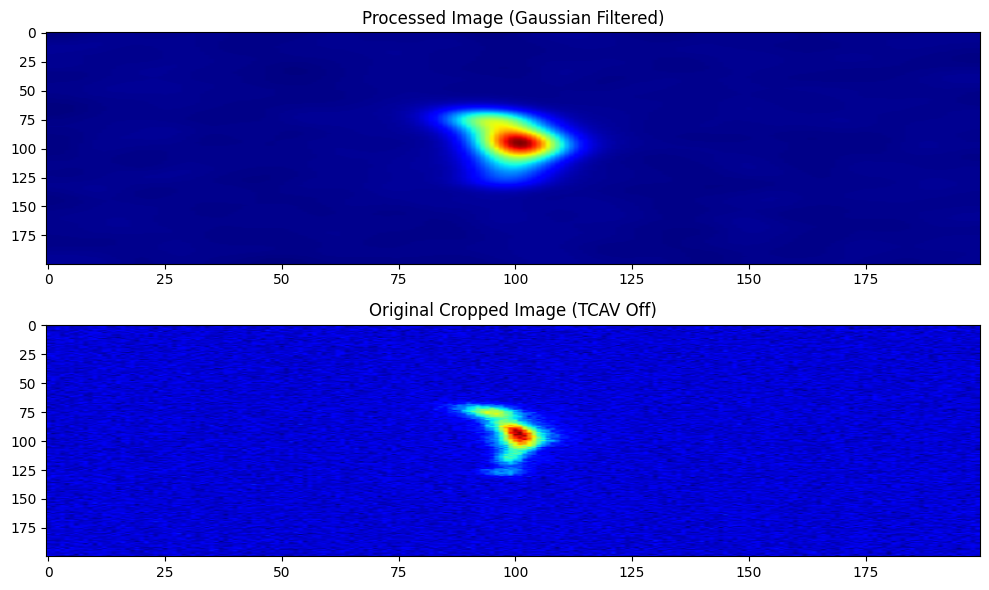

In [19]:
sample_image_tcav_off = xtcavImages[:, :, sample_image_indices[1]]
sample_image_tcav_off, _ = cropProfmonImg(sample_image_tcav_off, xrange, yrange, plot_flag=False)

img = median_filter(sample_image_tcav_off, size=3)
sigma = 5
processed_image = gaussian_filter(img, sigma=sigma)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.imshow(processed_image, cmap='jet', aspect='auto')
plt.title("Processed Image (Gaussian Filtered)")

plt.subplot(2, 1, 2)
plt.imshow(sample_image_tcav_off, cmap='jet', aspect='auto')
plt.title("Original Cropped Image (TCAV Off)")

plt.tight_layout()
plt.show()


In [20]:
def segment_centroids_and_com(image, nrows, return_com=True):
    """
    Segments the image row-wise and computes the center of mass for each row.

    Parameters:
    - image: 2D numpy array (cropped and processed XTCAV image)
    - nrows: int, number of rows (typically image.shape[0])
    - return_com: if True, returns center of mass positions; else returns only row indices

    Returns:
    - centroid_indices: numpy array of row indices (0 to nrows-1)
    - centers_of_mass: numpy array of COM along the horizontal axis for each row
    """

    height, width = image.shape
    centroid_indices = np.arange(nrows)
    centers_of_mass = np.zeros(nrows)

    for i in range(nrows):
        row = image[i, :]
        total_mass = np.sum(row)
        if total_mass > 0:
            x_coords = np.arange(width)
            com = np.sum(row * x_coords) / total_mass
        else:
            com = np.nan
        centers_of_mass[i] = com

    if return_com:
        return centroid_indices, centers_of_mass
    else:
        return centroid_indices

### Apply centroid correction to images and replot

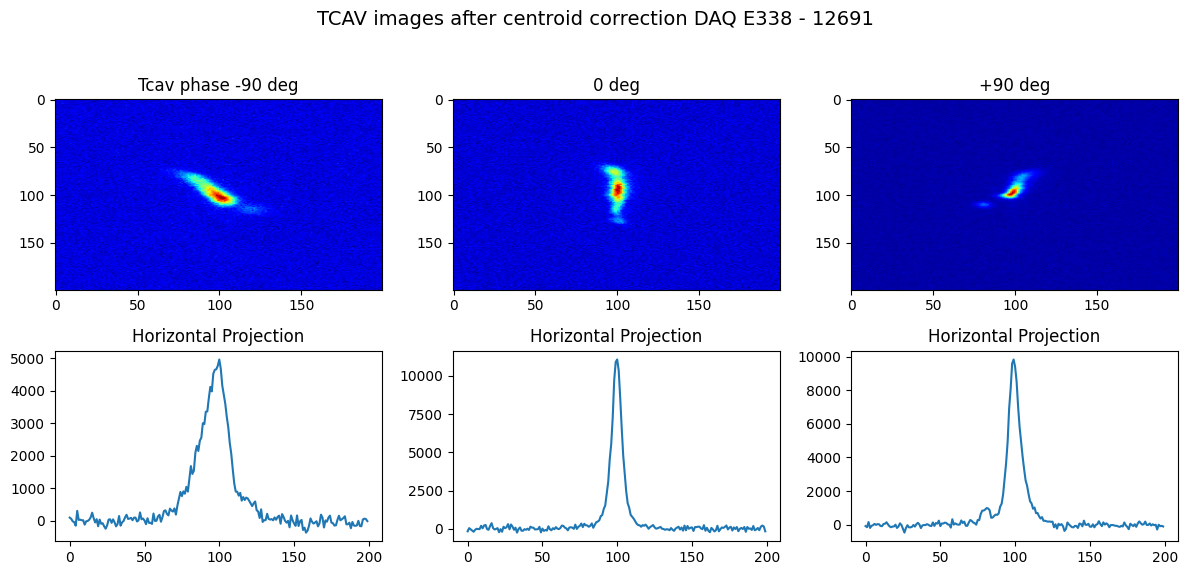

In [21]:
Nrows = np.array(sample_image_tcav_off).shape[0]
[centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle(f'TCAV images after centroid correction DAQ {experiment} - {runname}', fontsize=14)

for i, idx in enumerate(sample_image_indices):
    if idx is None:
        continue

    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)


    centroid_corrections = np.round((centers_of_mass/np.abs(centers_of_mass))*np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
    centroid_corrections[np.isnan(centroid_corrections)] = 0

    # Apply row-wise shift based on centroid correction
    sample_image_shifted = np.empty_like(sample_image_cropped)
    for row in range(sample_image_cropped.shape[0]):
        shift = -centroid_corrections[row]
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    horz_proj = np.sum(sample_image_shifted, axis=0)

    axs[0, i].imshow(sample_image_shifted, cmap='jet', aspect='auto')
    axs[0, i].set_title(plot_titles[i])

    axs[1, i].plot(horz_proj)
    axs[1, i].set_title("Horizontal Projection")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate the current profile normalizing the integral to the charge

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_76497/204033902.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)


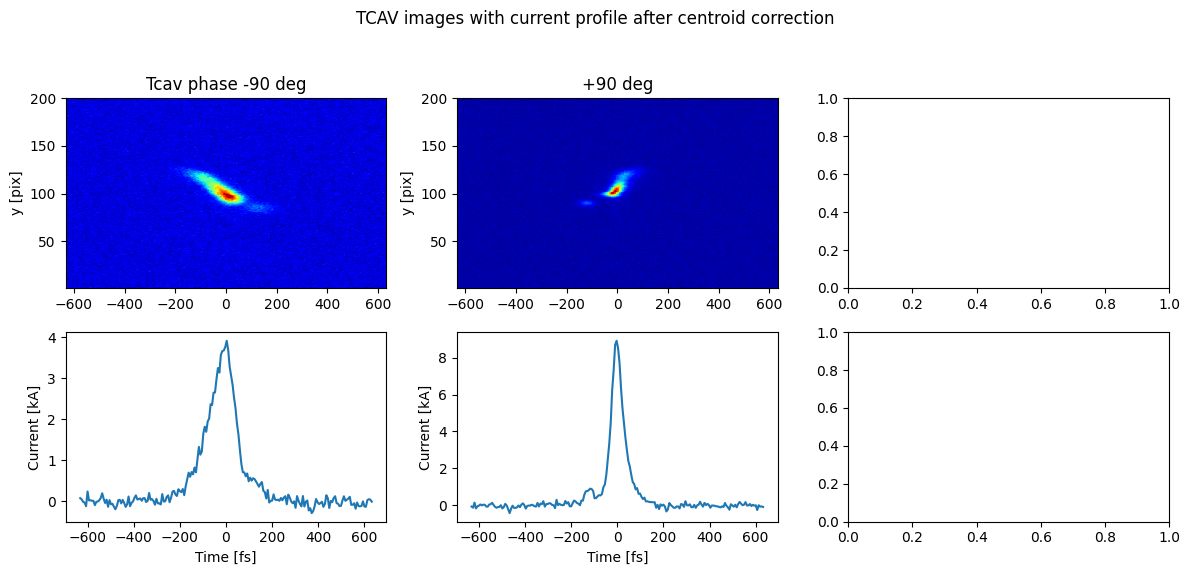

In [22]:
isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(isChargePV) if val]
charge = bsaScalarData[pvidx, :] * 1.6e-19  # in C 

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle(f'TCAV images with current profile after centroid correction')

for i, (ij, idx) in enumerate([(i, idx) for i, idx in enumerate(sample_image_indices) if i != 1]):
    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)

    # Centroid correction
    centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
    centroid_corrections[np.isnan(centroid_corrections)] = 0

    sample_image_shifted = np.empty_like(sample_image_cropped)
    for row in range(sample_image_cropped.shape[0]):
        shift = -int(centroid_corrections[row])
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    # Current profile
    streakedProfile = np.sum(sample_image_shifted, axis=0)
    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar -= np.median(tvar)
    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)
    currentProfile = streakedProfile * prefactor

    # Plot image
    axs[0, i].imshow(sample_image_shifted, cmap='jet', aspect='auto',
                     extent=[tvar[0]*1e15, tvar[-1]*1e15, 1, sample_image_shifted.shape[0]])
    axs[0, i].set_ylabel('y [pix]')
    axs[0, i].set_title(plot_titles[ij])

    # Plot projection
    axs[1, i].plot(tvar * 1e15, currentProfile * 1e-3)
    axs[1, i].set_xlabel('Time [fs]')
    axs[1, i].set_ylabel('Current [kA]')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Loop thru all +90 and -90 deg shots and calculate the current profile

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_76497/384535157.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)
/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_76497/384535157.py:59: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)


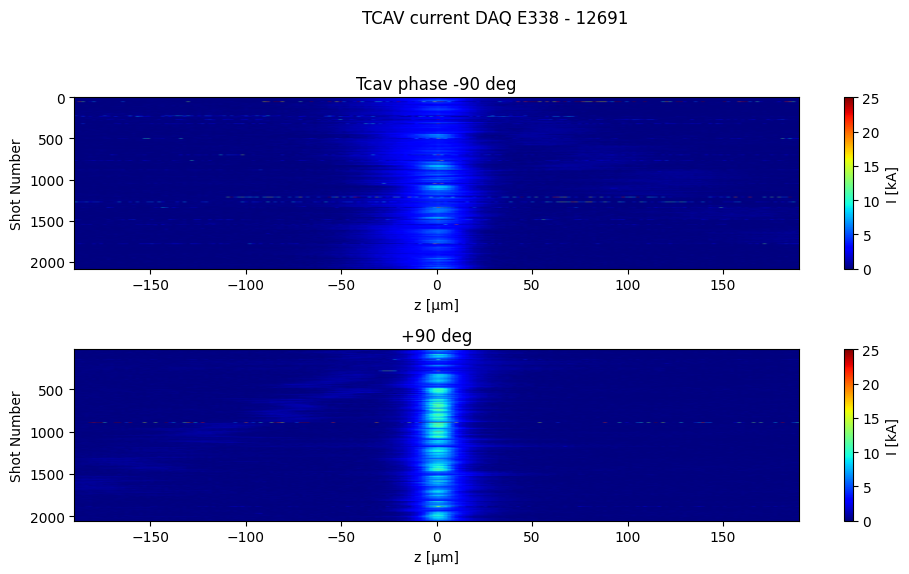

In [31]:
# Note here i'm assuming the centroid correction can be taken from a single 
#    tcav off image. A better treatment would find the nearest tcav off image
#   in the dataset and use that to apply the centroid correction on each shot

minus_90_idx = np.where((xtcavPhase >= -91) & (xtcavPhase <= -89))[0]
plus_90_idx = np.where((xtcavPhase >= 89) & (xtcavPhase <= 91))[0]

currentProfile_minus_90 = []
currentProfile_plus_90 = []

# Process -90 degree shots
for ij in range(len(minus_90_idx)):
    idx = minus_90_idx[ij]
    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)

    centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
    centroid_corrections[np.isnan(centroid_corrections)] = 0

    # Apply row-wise shift based on centroid correction
    sample_image_shifted = np.empty_like(sample_image_cropped)
    
    for row in range(sample_image_cropped.shape[0]):
        shift = -centroid_corrections[row]
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    # Calculate the current profile from the streaked projection
    streakedProfile = np.sum(sample_image_cropped, axis=0)

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_minus_90.append(currentProfile)

# Process +90 degree shots
for ij in range(len(plus_90_idx)):
    idx = plus_90_idx[ij]
    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)

    centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
    centroid_corrections[np.isnan(centroid_corrections)] = 0

    # Apply row-wise shift based on centroid correction
    sample_image_shifted = np.empty_like(sample_image_cropped)
    for row in range(sample_image_cropped.shape[0]):
        shift = -centroid_corrections[row]
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    # Calculate the current profile from the streaked projection
    streakedProfile = np.sum(sample_image_cropped, axis=0)

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_plus_90.append(currentProfile)

# Convert lists to arrays for plotting
currentProfile_minus_90 = np.array(currentProfile_minus_90)
currentProfile_plus_90 = np.array(currentProfile_plus_90)

# Plot
plt.figure(figsize=(10, 6))

# Subplot for -90°
plt.subplot(2, 1, 1)
extent_x = tvar * 3e8 * 1e6  # Convert to microns
plt.imshow(currentProfile_minus_90, aspect='auto', cmap='jet', vmin=0, vmax=25, extent=[extent_x[0], extent_x[-1], minus_90_idx[-1], minus_90_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title(plot_titles[0])
plt.colorbar(label='I [kA]')

# Subplot for +90°
plt.subplot(2, 1, 2)
plt.imshow(currentProfile_plus_90, aspect='auto', cmap='jet', vmin=0, vmax=25,extent=[extent_x[0], extent_x[-1], plus_90_idx[-1], plus_90_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title(plot_titles[2])
plt.colorbar(label='I [kA]')

plt.suptitle(f"TCAV current DAQ {experiment} - {runname}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate the drive-witness separation and compare with BLEN

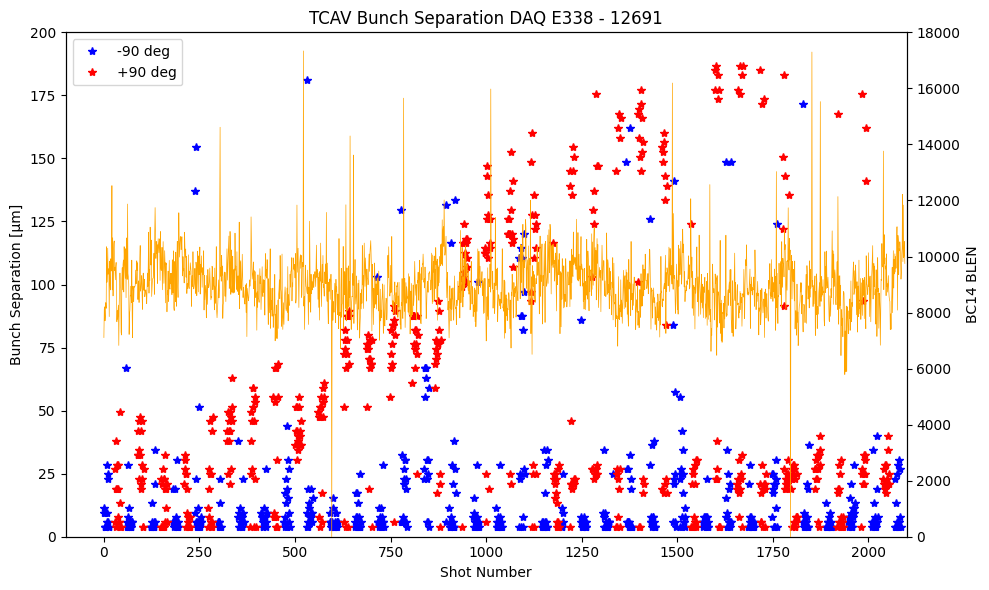

In [35]:
ispv = [bool(re.search(r'BLEN_LI14_888_BRAW', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(ispv) if val]
bc14BLEN = bsaScalarData[pvidx,:]
separationCutoff = 0.05 # fraction of the drive/witness peak current for filtering

sorted_bc14BLEN = np.sort(bc14BLEN)
sort_BC14BLEN_indices = np.argsort(bc14BLEN)

from scipy.signal import find_peaks

bunchSeparation_minus_90 = np.zeros(len(minus_90_idx))
currentRatio_minus_90 = np.zeros(len(minus_90_idx))

for ij in range(len(minus_90_idx)):
    profile = currentProfile_minus_90[ij, :]
    peaks, properties = find_peaks(profile)
    prominences = properties.get("prominences", profile[peaks])  # fallback to height if no prominences

    if len(prominences) < 2:
        bunchSeparation_minus_90[ij] = 0
        continue

    top2_indices = np.argsort(prominences)[-2:]
    pos = peaks[top2_indices]

    peak_separation = abs(pos[0] - pos[1])

    if abs(prominences[top2_indices[0]]) * separationCutoff > abs(prominences[top2_indices[1]]):
        peak_separation = 0

    bunchSeparation_minus_90[ij] = peak_separation * xtcalibrationfactor
    currentRatio_minus_90[ij] = profile[pos[0]] / profile[pos[1]]

bunchSeparation_plus_90 = np.zeros(len(plus_90_idx))
currentRatio_plus_90 = np.zeros(len(plus_90_idx))

for ij in range(len(plus_90_idx)):
    profile = currentProfile_plus_90[ij, :]
    peaks, properties = find_peaks(profile)
    prominences = properties.get("prominences", profile[peaks])

    if len(prominences) < 2:
        bunchSeparation_plus_90[ij] = 0
        continue

    top2_indices = np.argsort(prominences)[-2:]
    pos = peaks[top2_indices]

    peak_separation = abs(pos[0] - pos[1])

    if abs(prominences[top2_indices[0]]) * separationCutoff > abs(prominences[top2_indices[1]]):
        peak_separation = 0

    bunchSeparation_plus_90[ij] = peak_separation * xtcalibrationfactor
    currentRatio_plus_90[ij] = profile[pos[0]] / profile[pos[1]]

# Convert to microns
bunch_sep_minus_90_um = bunchSeparation_minus_90 * 3e8 * 1e6
bunch_sep_plus_90_um = bunchSeparation_plus_90 * 3e8 * 1e6

# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bunch separations
ln1 = ax1.plot(minus_90_idx, bunch_sep_minus_90_um, '*b', label='-90 deg')
ln2 = ax1.plot(plus_90_idx, bunch_sep_plus_90_um, '*r', label='+90 deg')

ax1.set_xlabel('Shot Number')
ax1.set_ylabel('Bunch Separation [μm]', color='black')
ax1.set_ylim(0, 200)  

# Create secondary y-axis for BC14 BLEN
ax2 = ax1.twinx()
shot_numbers = np.arange(bc14BLEN.shape[1])
ln3 = ax2.plot(shot_numbers,bc14BLEN[0], color = 'orange', linewidth=0.5)
ax2.set_ylabel('BC14 BLEN', color='black')
ax2.set_ylim(0, 18000)

# Combine legends
lines = ln1 + ln2 
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Title and appearance
plt.title(f'TCAV Bunch Separation DAQ {experiment} - {runname}')
plt.xlim((-100,2100))
fig.tight_layout()
fig.patch.set_facecolor('white')

plt.show()


### Calculate the charge in the drive and witness beams based on DTOTR projection

In [36]:
steps = data_struct.scalars.steps[DTOTR2commonind]
energyProjection = np.sum(xtcavImages, axis=1)

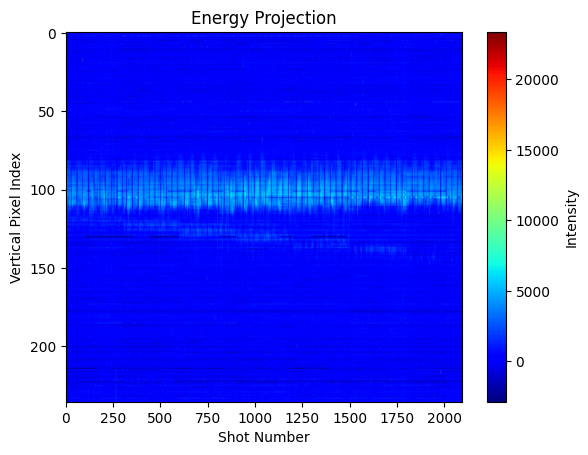

In [37]:
plt.figure()
plt.imshow(energyProjection, aspect='auto', cmap='jet')
plt.title("Energy Projection")
plt.xlabel("Shot Number")
plt.ylabel("Vertical Pixel Index")
plt.colorbar(label='Intensity')
plt.show()

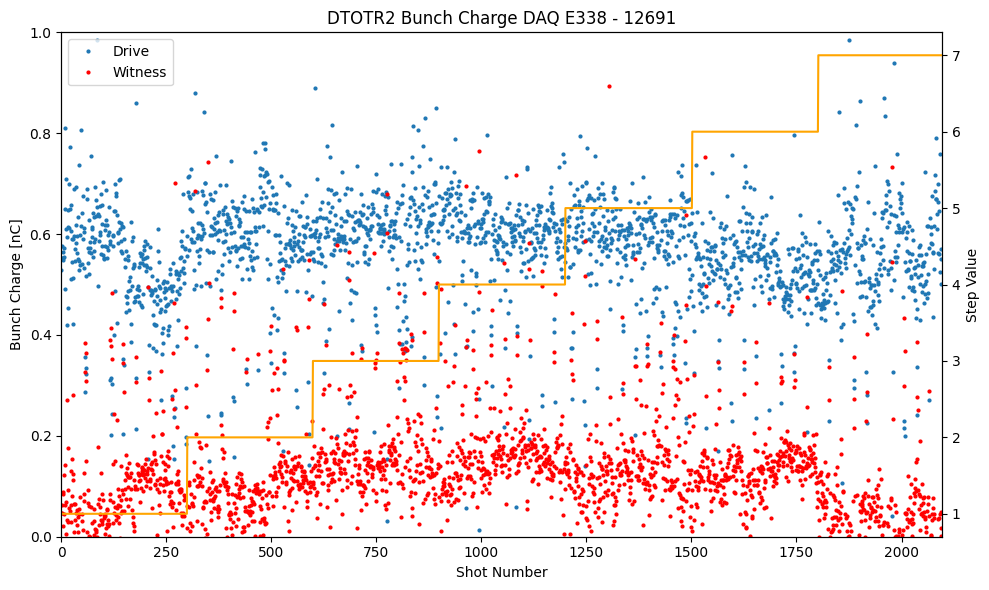

In [38]:
idxDrive = 115 # index in the energy projection that separates Drive-witness - determine it by looking at the above waterfall plot

driveBeamEnergyProj = energyProjection[:idxDrive, :] 
witnessBeamEnergyProj = energyProjection[idxDrive:, :] 

chargeInDrive = charge * np.sum(driveBeamEnergyProj, axis=0) / np.sum(energyProjection, axis=0)
chargeInWitness = charge * np.sum(witnessBeamEnergyProj, axis=0) / np.sum(energyProjection, axis=0)

plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Left y-axis
ax1.set_ylabel('Bunch Charge [nC]')
ax1.set_ylim(0, 1)
ln1 = ax1.plot(chargeInDrive[0] * 1e9, '.', label='Drive', ms = 4)
ln2 = ax1.plot(chargeInWitness[0] * 1e9, '.r', label='Witness', ms = 4)

# Right y-axis (step values)
ax2 = ax1.twinx()
ln3 = ax2.plot(steps, '-', color='orange', label='Step Value')
ax2.set_ylabel('Step Value')

# X-axis
ax1.set_xlabel('Shot Number')
ax1.set_xlim([0, len(steps)])

# Combine legend from both axes
lines = ln1 + ln2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title(f'DTOTR2 Bunch Charge DAQ {experiment} - {runname}')
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

### Calculate the charge in the drive and witness beams based on SYAG projection

In [28]:
SYAGdata = None

for a in range(len(stepsAll)):
    raw_path = data_struct.images.SYAG.loc[a]
    match = re.search(rf'({experiment}_\d+/images/SYAG/SYAG_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    SYAGdatalocation = './E338/' + match.group(0)

    with h5py.File(SYAGdatalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    # Transpose to shape: (H, W, N)
    data_transposed = np.transpose(data_raw, (2, 1, 0))

    if SYAGdata is None:
        SYAGdata = data_transposed
    else:
        SYAGdata = np.concatenate((SYAGdata, data_transposed), axis=2)

KeyboardInterrupt: 

In [ ]:
# Keeps only the data with a common index
SYAGcommonind = data_struct.images.SYAG.common_index -1 
SYAGdata = SYAGdata[:, :, SYAGcommonind]

In [ ]:
syagImages = SYAGdata - data_struct.backgrounds.SYAG[:,:,np.newaxis].astype(np.float64)
syagProjection = np.sum(syagImages, axis=1)

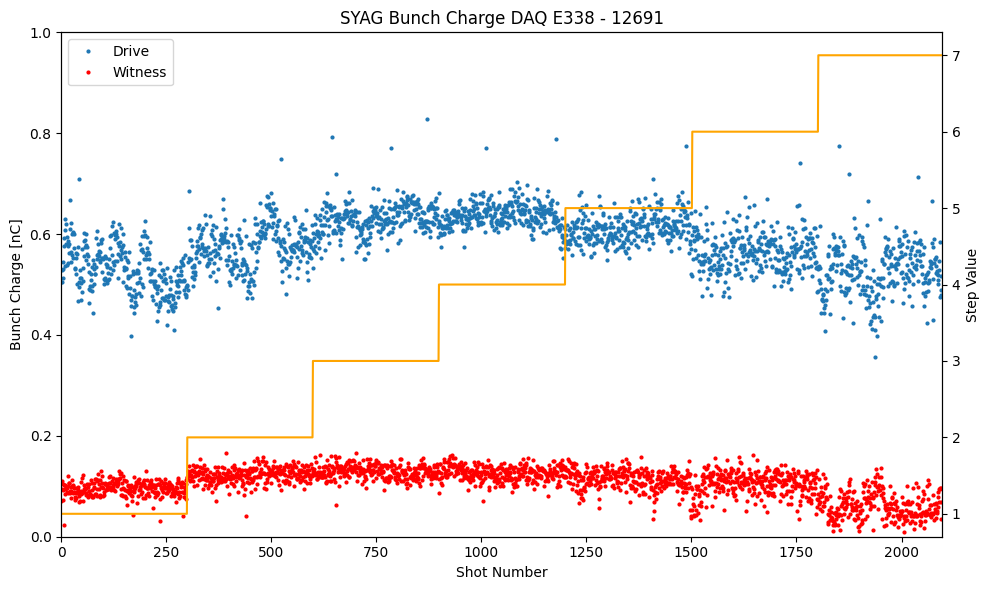

In [ ]:
idxDrive = 670 # index in the energy projection that separates Drive-witness - determine it by looking at the above waterfall plot

driveBeamsyagProj = syagProjection[:idxDrive, :] 
witnessBeamsyagProj = syagProjection[idxDrive:, :] 

chargeInDriveFromSyag = charge * np.sum(driveBeamsyagProj, axis=0) / np.sum(syagProjection, axis=0)
chargeInWitnessFromSyag = charge * np.sum(witnessBeamsyagProj, axis=0) / np.sum(syagProjection, axis=0)

plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Left y-axis
ax1.set_ylabel('Bunch Charge [nC]')
ax1.set_ylim(0, 1)
ln1 = ax1.plot(chargeInDriveFromSyag[0] * 1e9, '.', label='Drive', ms = 4)
ln2 = ax1.plot(chargeInWitnessFromSyag[0] * 1e9, '.r', label='Witness', ms = 4)

# Right y-axis (step values)
ax2 = ax1.twinx()
ln3 = ax2.plot(steps, '-', color='orange', label='Step Value')
ax2.set_ylabel('Step Value')

# X-axis
ax1.set_xlabel('Shot Number')
ax1.set_xlim([0, len(steps)])

# Combine legend from both axes
lines = ln1 + ln2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title(f'SYAG Bunch Charge DAQ {experiment} - {runname}')
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

### 2d Heatmap

In [40]:
bunchSeparation_minus_90.shape

(563,)

In [41]:
def plot2DbunchseparationVsCollimatorAndBLEN(bc14BLEN, step_vals, bunchSeparation, idx_list, subplot_index, title, N, caxis_limits):
    plt.subplot(1, 2, subplot_index)
    
    # Build 2D histogram grid
    hist2d, xedges, yedges = np.histogram2d(
        bc14BLEN[0][idx_list], step_vals[idx_list],
        bins=N,
        weights=bunchSeparation[idx_list] * 3e8 * 1e6  # Convert to microns
    )
    
    # Count for normalization
    counts, _, _ = np.histogram2d(
        bc14BLEN[0][idx_list], step_vals[idx_list], bins=[xedges, yedges]
    )
    
    # Avoid divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_hist2d = np.where(counts > 0, hist2d / counts, np.nan)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    im = plt.imshow(avg_hist2d.T, origin='lower', aspect='auto', extent=extent, cmap='jet', vmin=caxis_limits[0], vmax=caxis_limits[1])
    plt.xlabel('BC14 BLEN')
    plt.ylabel('Notch Position')
    plt.title(title)
    plt.colorbar(im, label='Bunch Separation [μm]')

IndexError: index 591 is out of bounds for axis 0 with size 563

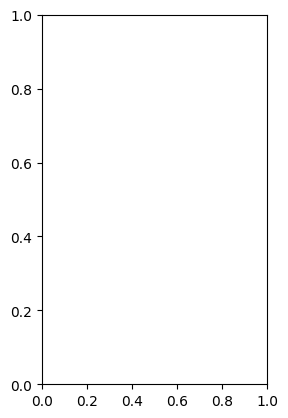

In [42]:
# Define constants 
N = 200
caxis_limits = [0,250]
figure_position = [100,100,1500,500]

# Plot -90 deg data
plot2DbunchseparationVsCollimatorAndBLEN(
    bc14BLEN, steps, bunchSeparation_minus_90, minus_90_idx, 1, '-90 deg', N, caxis_limits
)

# Plot +90 deg data
plot2DbunchseparationVsCollimatorAndBLEN(
    bc14BLEN, steps, bunchSeparation_plus_90, plus_90_idx, 2, '+90 deg', N, caxis_limits
)

plt.suptitle(f'DTOTR2 bunch separation vs notch pos & BLEN {experiment} - {runname}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Now fit a 2D function to the data an plot the surface

In [90]:
# Define the data
X = bc14BLEN[0][plus_90_idx]
Y = steps[plus_90_idx]
Z = bunch_sep_plus_90_um # in microns 

# Filter good shots
goodShots = np.where((Z < 250) & (Z > 0))
X = X[goodShots]
Y = Y[goodShots]
Z = Z[goodShots]

# Combine X and Y into a matrix with two columns
XY = np.column_stack((X, Y))


In [100]:
# Fit a polynomial surface to the data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata

poly = PolynomialFeatures(degree=2)
XY_poly = poly.fit_transform(XY)

fit_model = LinearRegression()
fit_model.fit(XY_poly, Z)

Z_fit = fit_model.predict(XY_poly)

print("Polynomial Coefficients:", fit_model.coef_)
print("Intercept:", fit_model.intercept_)


Polynomial Coefficients: [ 0.00000000e+00  1.68206922e-02  4.39180054e+01 -1.18402269e-06
  1.28365217e-03 -6.56513964e+00]
Intercept: -90.30979211493496


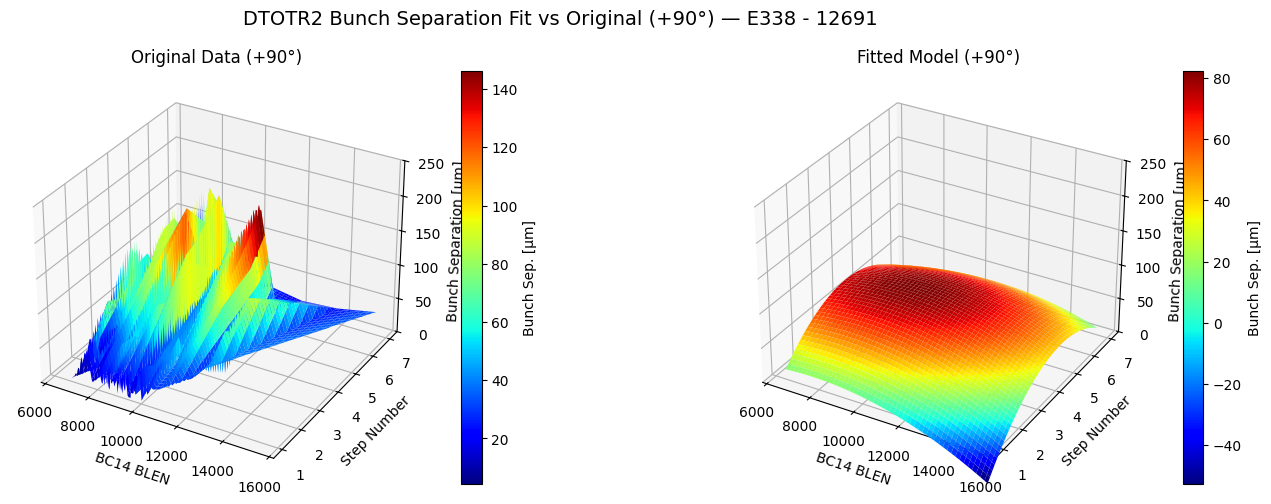

In [101]:
# Create a grid for plotting
N = 200
x = np.linspace(np.min(X), np.max(X), N)
y = np.linspace(np.min(Y), np.max(Y), N)
Xi, Yi = np.meshgrid(x, y)

# Evaluate the fitted model on the grid
XYi_poly = poly.transform(np.column_stack((Xi.ravel(), Yi.ravel())))
Zi_fit = model.predict(XYi_poly).reshape(Xi.shape)

# Interpolate original Z data onto the grid
Zi_data = griddata((X, Y), Z, (Xi, Yi), method='linear')

# Create figure
fig = plt.figure(figsize=(15, 5))

# Plot original data
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(Xi, Yi, Zi_data, cmap='jet', edgecolor='none')
ax1.set_title('Original Data (+90°)')
ax1.set_xlabel('BC14 BLEN')
ax1.set_ylabel('Step Number')
ax1.set_zlabel('Bunch Separation [μm]')
fig.colorbar(surf1, ax=ax1, label='Bunch Sep. [μm]')
ax1.set_zlim(0, 250)

# Plot fitted model
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(Xi, Yi, Zi_fit, cmap='jet', edgecolor='none')
ax2.set_title('Fitted Model (+90°)')
ax2.set_xlabel('BC14 BLEN')
ax2.set_ylabel('Step Number')
ax2.set_zlabel('Bunch Separation [μm]')
fig.colorbar(surf2, ax=ax2, label='Bunch Sep. [μm]')
ax2.set_zlim(0, 250)

plt.suptitle(f'DTOTR2 Bunch Separation Fit vs Original (+90°) — {experiment} - {runname}', fontsize=14)
plt.tight_layout()
plt.show()

### Calculate the bunch length in the drive and witness beams by fitting a biGaussian

In [109]:
from scipy.optimize import curve_fit

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_76497/2574704450.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)


Fit failed at index 367
Fit failed at index 369
Fit failed at index 391
Fit failed at index 437
Fit failed at index 453
Fit failed at index 457
Fit failed at index 501


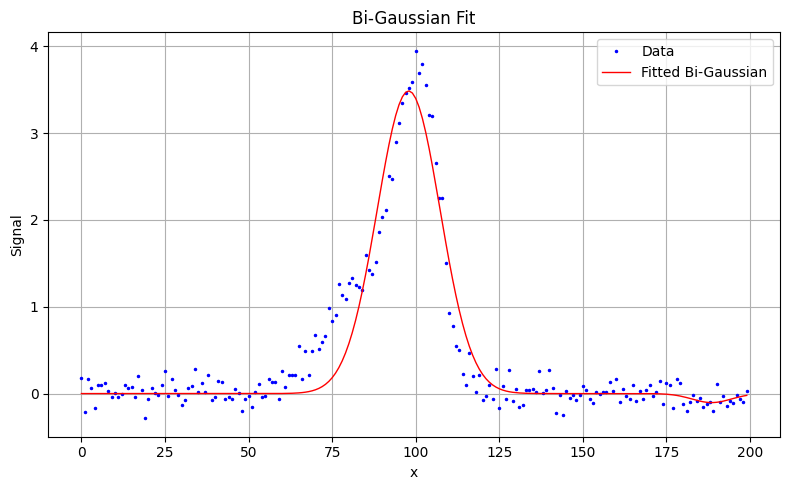

In [130]:
# fit bi-Gaussian to -90 deg 
y = currentProfile_minus_90[0,:]

# Define the bi-Gaussian function
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

mean1 = []
mean2 = []
sigma1 = []
sigma2 = []
R_squared = []

for ij in range(len(minus_90_idx)):
    y = currentProfile_minus_90[ij, :]
    x = np.arange(len(y))

    # Initial guess: [A1, mu1, sigma1, A2, mu2, sigma2]
    initial_guess = [np.max(y), 150, 4, np.max(y)*0.1, 100 + ij * 0.15, 4]

    try:
        popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)
    except RuntimeError:
        print(f"Fit failed at index {ij}")
        mean1.append(np.nan)
        mean2.append(np.nan)
        sigma1.append(np.nan)
        sigma2.append(np.nan)
        R_squared.append(np.nan)
        continue

    # Extract parameters
    A1, mu1_val, sig1, A2, mu2_val, sig2 = popt
    mean1.append(mu1_val)
    mean2.append(mu2_val)
    sigma1.append(sig1)
    sigma2.append(sig2)

    # Evaluate fit
    y_fit = bi_gaussian(x, *popt)
    SST = np.sum((y - np.mean(y))**2)
    SSR = np.sum((y - y_fit)**2)
    R_squared.append(1 - SSR / SST)

# Convert results to arrays
mean1 = np.array(mean1)
mean2 = np.array(mean2)
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
R_squared = np.array(R_squared)

# Plot the sigma of the drive and witness
# Plot the data and the fit
zvar = tvar * 3e8 * 1e6  # in microns
sigmadrive_minus90 = sigma1 * abs(zvar[1] - zvar[0])
sigmawit_minus90 = sigma2 * abs(zvar[1] - zvar[0])

# Plot a single fit (last one by default)
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data', ms = 3)
plt.plot(x, bi_gaussian(x, *popt), 'r-', label='Fitted Bi-Gaussian', linewidth = 1)
plt.xlabel('x')
plt.ylabel('Signal')
plt.title('Bi-Gaussian Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_76497/2525424262.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)


Fit failed at index 367
Fit failed at index 369
Fit failed at index 391
Fit failed at index 437
Fit failed at index 453
Fit failed at index 457
Fit failed at index 501


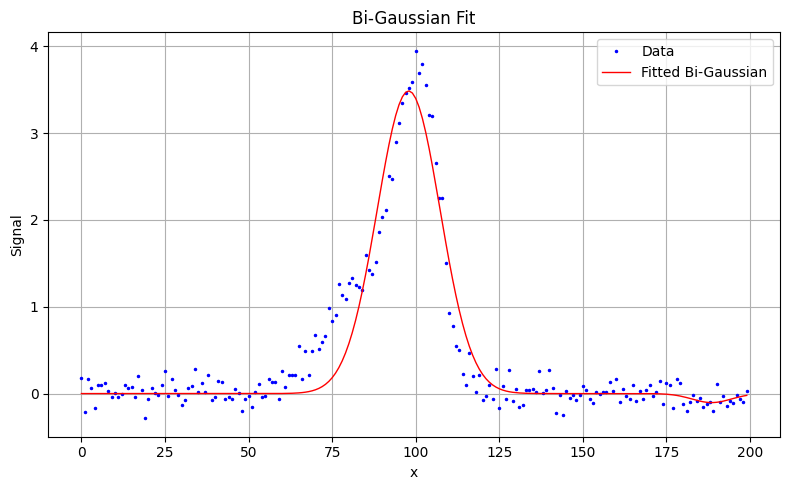

In [132]:
# fit bi-Gaussian to +90 deg 
y = currentProfile_plus_90[0,:]

# Define the bi-Gaussian function
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

mean1 = []
mean2 = []
sigma1 = []
sigma2 = []
R_squared = []

for ij in range(len(minus_90_idx)):
    y = currentProfile_minus_90[ij, :]
    x = np.arange(len(y))

    # Initial guess: [A1, mu1, sigma1, A2, mu2, sigma2]
    initial_guess = [np.max(y), 150, 4, np.max(y)*0.1, 100 + ij * 0.15, 4]

    try:
        popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)
    except RuntimeError:
        print(f"Fit failed at index {ij}")
        mean1.append(np.nan)
        mean2.append(np.nan)
        sigma1.append(np.nan)
        sigma2.append(np.nan)
        R_squared.append(np.nan)
        continue

    # Extract parameters
    A1, mu1_val, sig1, A2, mu2_val, sig2 = popt
    mean1.append(mu1_val)
    mean2.append(mu2_val)
    sigma1.append(sig1)
    sigma2.append(sig2)

    # Evaluate fit
    y_fit = bi_gaussian(x, *popt)
    SST = np.sum((y - np.mean(y))**2)
    SSR = np.sum((y - y_fit)**2)
    R_squared.append(1 - SSR / SST)

# Convert results to arrays
mean1 = np.array(mean1)
mean2 = np.array(mean2)
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
R_squared = np.array(R_squared)

# Plot the sigma of the drive and witness
# Plot the data and the fit
zvar = tvar * 3e8 * 1e6  # in microns
sigmadrive_minus90 = sigma1 * abs(zvar[1] - zvar[0])
sigmawit_minus90 = sigma2 * abs(zvar[1] - zvar[0])

# Plot a single fit (last one by default)
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data', ms = 3)
plt.plot(x, bi_gaussian(x, *popt), 'r-', label='Fitted Bi-Gaussian', linewidth = 1)
plt.xlabel('x')
plt.ylabel('Signal')
plt.title('Bi-Gaussian Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Prepare data for ML model prediction of the driver current

In [155]:
driverPeak = np.max(currentProfile_plus_90, axis = 1)
predictor = bsaScalarData[:,plus_90_idx]

/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


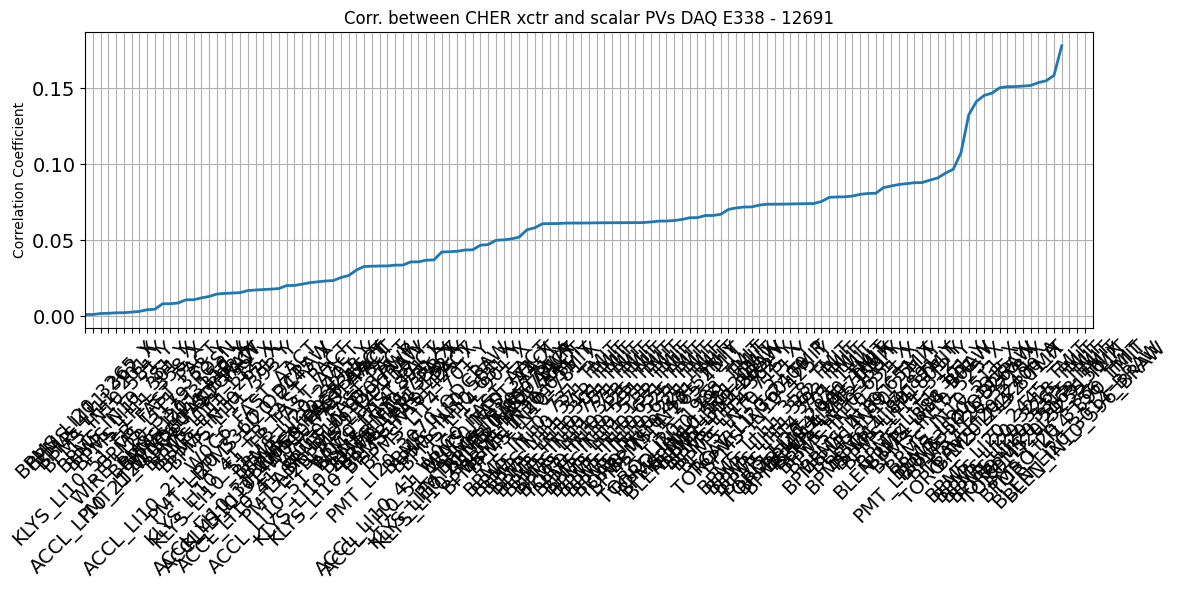

In [156]:
# Plot correlation coefficient between image data and all bsa scalar PVs
    # cut out all the shots with l2 phase of 38 deg;
c = []

for n in range(predictor.shape[0]):
    x = predictor[n, :]
    y = driverPeak
    R = np.corrcoef(x, y)
    c.append(R[0, 1])

c = np.array(c)
absc = np.abs(c)
idx = np.argsort(absc)

plt.figure(figsize=(12, 6))
plt.plot(absc[idx], linewidth=2)
plt.grid(True)
plt.box(True)
plt.ylabel('Correlation Coefficient')
plt.xticks(ticks=np.arange(len(bsaVars)), labels=np.array(bsaVars)[idx], rotation=45, fontsize=10)
plt.xlim([0, len(absc)])
plt.title(f'Corr. between CHER xctr and scalar PVs DAQ {experiment} - {runname}')
plt.gca().tick_params(axis='both', labelsize=14)
plt.gcf().set_facecolor('white')
plt.tight_layout()
plt.show()
